# 1. Introduction

In the contemporary landscape of urban transportation, car accidents remain a significant concern with far-reaching implications for public safety and road infrastructure. Analyzing the factors contributing to accidents and understanding their severity is crucial for devising effective preventive measures and enhancing road safety standards. This project aims to explore the details of car accidents by leveraging a comprehensive dataset, shedding light on patterns, key determinants, and use a predictive model for accident severity.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

accidents = pd.read_csv("D:\\minor_project\\us accident data\\US_Accidents_March23.csv", nrows=500000, parse_dates=['Start_Time', 'End_Time'])

display(accidents.head())

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


# 2. Data Exploration and Preprocessing:

Before delving into the heart of our analysis, let's check the main characteristics of the dataset to ensure its quality and relevance. The dataset, encompassing a diverse range of attributes such as accident severity, weather conditions, road features, and temporal characteristics, should be examined for missing values, outliers, and inconsistencies.

In [16]:
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])

# Extracting only the year
accidents['year'] = accidents['Start_Time'].dt.year

In [17]:
accidents.isna().mean()

ID                       0.000000
Source                   0.000000
Severity                 0.000000
Start_Time               0.000000
End_Time                 0.000000
Start_Lat                0.000000
Start_Lng                0.000000
End_Lat                  1.000000
End_Lng                  1.000000
Distance(mi)             0.000000
Description              0.000000
Street                   0.000000
City                     0.000044
County                   0.000000
State                    0.000000
Zipcode                  0.000116
Country                  0.000000
Timezone                 0.000116
Airport_Code             0.000120
Weather_Timestamp        0.008230
Temperature(F)           0.014500
Wind_Chill(F)            0.875282
Humidity(%)              0.015830
Pressure(in)             0.011478
Visibility(mi)           0.021078
Wind_Direction           0.008294
Wind_Speed(mph)          0.178080
Precipitation(in)        0.896108
Weather_Condition        0.020370
Amenity       

In [18]:
null_columns = ['End_Lat', 'End_Lng', 'Wind_Chill(F)']

accidents = accidents.drop(null_columns, axis=1)

In [19]:
{column: len(accidents[column].unique()) for column in accidents.columns if accidents.dtypes[column] == 'object'}

{'ID': 500000,
 'Source': 2,
 'Description': 347298,
 'Street': 45167,
 'City': 4458,
 'County': 584,
 'State': 29,
 'Zipcode': 77299,
 'Country': 1,
 'Timezone': 5,
 'Airport_Code': 664,
 'Weather_Timestamp': 114548,
 'Wind_Direction': 25,
 'Weather_Condition': 71,
 'Sunrise_Sunset': 3,
 'Civil_Twilight': 3,
 'Nautical_Twilight': 3,
 'Astronomical_Twilight': 3}

In [20]:
# Put coordinates in a different dataframe for later use
accident_coords = accidents[['Start_Lat', 'Start_Lng']][:1000000].copy()
accident_coords = round(accident_coords, 2)

# Drop columns that won't be used for the analysis
accidents.drop(columns=['ID',
                        'Description',
                        'Start_Lat', 
                        'Start_Lng', 
                        'County',
                        'Weather_Timestamp',
                        'Zipcode', 
                        'Civil_Twilight', 
                        'Nautical_Twilight', 
                        'Astronomical_Twilight',
                        'Timezone', 
                        'Airport_Code',
                       'Traffic_Calming',
                        'Turning_Loop',
                        'Sunrise_Sunset',
                       'Pressure(in)',
                       'Wind_Direction'], inplace=True)

# Display main data characteristics
display(round(accidents.describe()))

display(accidents.info())

display(round(accidents.isnull().sum()))

,Severity,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),year
count,500000.0,500000.0,492750.0,492085.0,489461.0,410960.0,51946.0,500000.0
mean,2.0,0.0,65.0,65.0,9.0,9.0,0.0,2016.0
std,0.0,1.0,17.0,21.0,2.0,5.0,1.0,0.0
min,1.0,0.0,-78.0,4.0,0.0,0.0,0.0,2016.0
25%,2.0,0.0,55.0,49.0,10.0,6.0,0.0,2016.0
50%,2.0,0.0,66.0,66.0,10.0,8.0,0.0,2016.0
75%,3.0,0.0,77.0,82.0,10.0,12.0,0.0,2017.0
max,4.0,90.0,162.0,100.0,111.0,823.0,10.0,2017.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Source             500000 non-null  object        
 1   Severity           500000 non-null  int64         
 2   Start_Time         500000 non-null  datetime64[ns]
 3   End_Time           500000 non-null  datetime64[ns]
 4   Distance(mi)       500000 non-null  float64       
 5   Street             500000 non-null  object        
 6   City               499978 non-null  object        
 7   State              500000 non-null  object        
 8   Country            500000 non-null  object        
 9   Temperature(F)     492750 non-null  float64       
 10  Humidity(%)        492085 non-null  float64       
 11  Visibility(mi)     489461 non-null  float64       
 12  Wind_Speed(mph)    410960 non-null  float64       
 13  Precipitation(in)  51946 non-null   float64 

None

Source                    0
Severity                  0
Start_Time                0
End_Time                  0
Distance(mi)              0
Street                    0
City                     22
State                     0
Country                   0
Temperature(F)         7250
Humidity(%)            7915
Visibility(mi)        10539
Wind_Speed(mph)       89040
Precipitation(in)    448054
Weather_Condition     10185
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Signal            0
year                      0
dtype: int64

* From this information we can see that there are some missing values in a few columns. We'll deal with them while preprocssing the data for the ML model;
* We can use some of the columns to derive new useful information about the car crashes;
* It's good to see that there are no negative values where they shouldn't exist (for example, negative precipitation), which means we don't have to hunt for very weird data.

# 3. Exploratory Data Analysis (EDA):

In the upcoming phase of our analysis, we are poised to construct a series of informative visualizations as part of our Exploratory Data Analysis (EDA). Our strategic visualization approach encompasses the following key objectives:

* Temporal Patterns and Severity Analysis

We will make a detailed breakdown of accident events by hour. But our focus goes beyond mere representation. Our visualizations will show how severe the accidents are and how often they happen. This picture will help us see how things change during the 24-h period and how they affect accident frequency and severity.

* Correlation of Severity with Roadway Attributes

A crucial aspect of our analysis lies in the examination of how diverse road features influence accident severity. I will use a correlation chart that show how accidents are related to different road characteristics. These insights might offer a deeper understanding of the variables that may exacerbate or mitigate accident severity.

* Spatial Insight through Heatmapping

I'll make a spatial analysis is in the form of a geographically oriented heatmap, which shows where accidents are more likely to happen. This visualization leverages a gradient spectrum to portray the density of accidents, enabling us to pinpoint specific regions that demand closer attention. 

## Temporal Breakdown

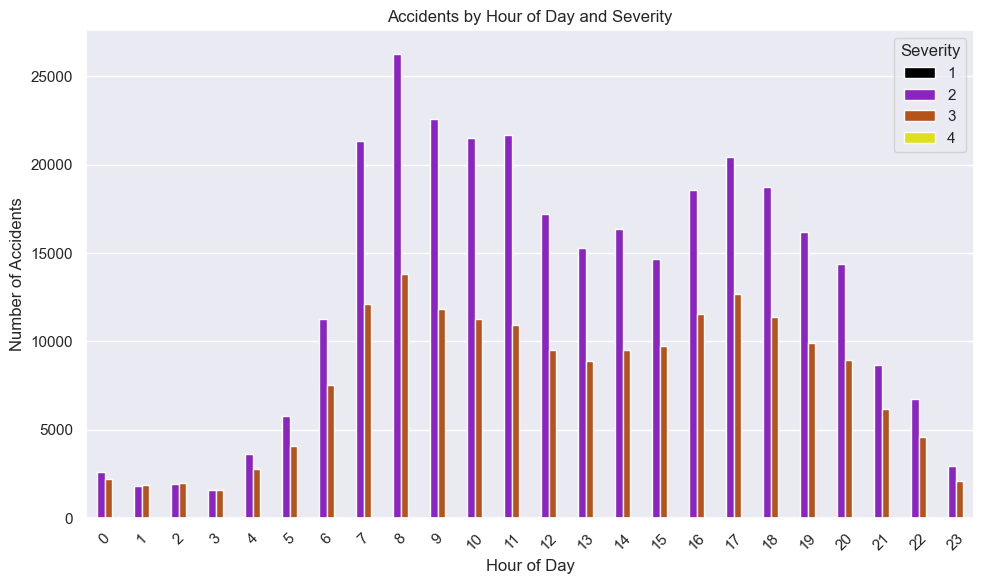

In [21]:
# Set chart style
palette=sns.color_palette('gnuplot')
sns.set(style="darkgrid", palette="gnuplot", context="notebook",)
# Extract hour of day from 'Start_Time'
accidents['Hour_of_Day'] = accidents['Start_Time'].dt.hour

# Create a new dataset with 'Severity' and 'Hour_of_Day' columns
severity_hour_dataset = accidents[['Severity', 'Hour_of_Day']].copy()

# Task 3: Create a Seaborn countplot to visualize accidents by hour and severity
plt.figure(figsize=(10, 6))
sns.countplot(data=severity_hour_dataset, x='Hour_of_Day', hue='Severity', palette='gnuplot')
plt.title('Accidents by Hour of Day and Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

* The accidents are clearly affected by the time of day. As expected, most accidents occur during commute from home to work or from work to home.

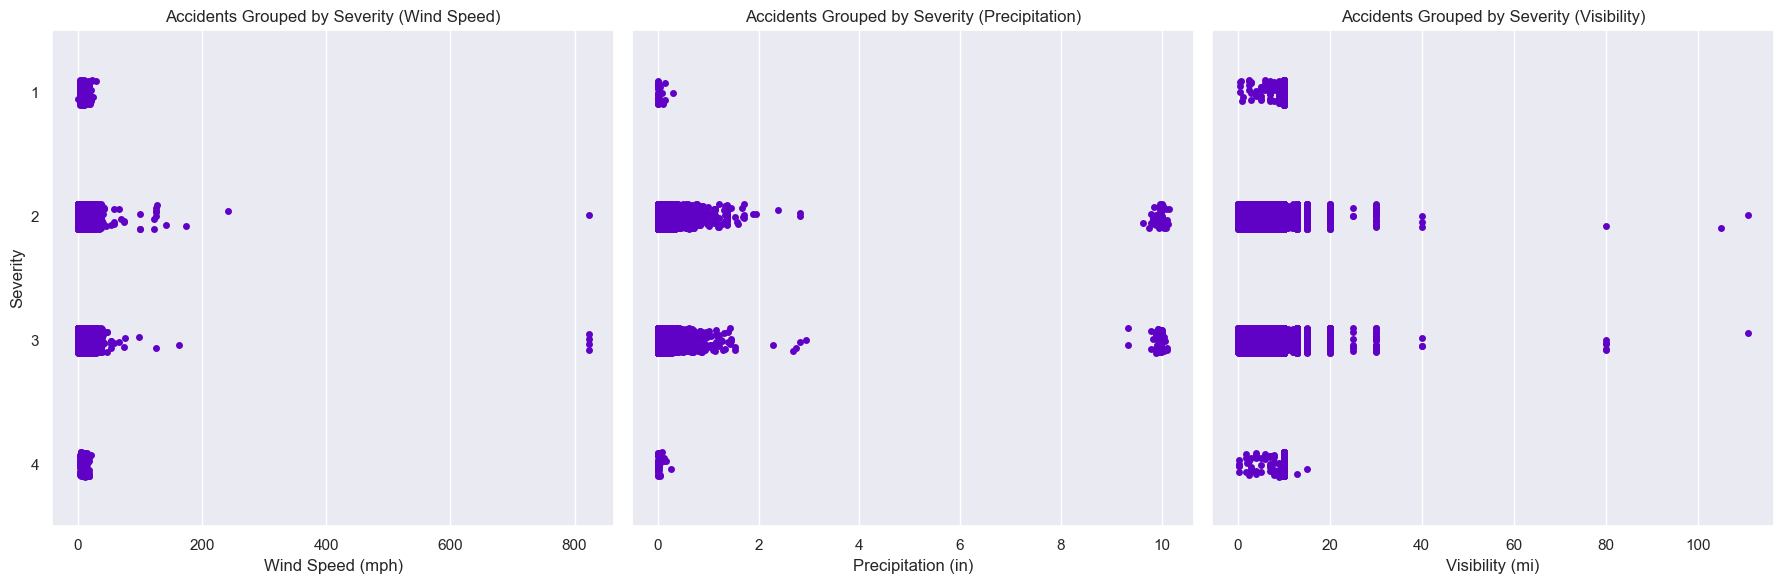

In [22]:
# Change Severity to Category for this chart
accidents['Severity'] = accidents['Severity'].astype('category')

# Create a unified set of axes and a figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

# Scatterplot for Wind Speed
sns.stripplot(data=accidents, x='Wind_Speed(mph)', y='Severity', ax=axes[0])
axes[0].set_title('Accidents Grouped by Severity (Wind Speed)')
axes[0].set_xlabel('Wind Speed (mph)')
axes[0].set_ylabel('Severity')

# Scatterplot for Precipitation
sns.stripplot(data=accidents, x='Precipitation(in)', y='Severity', ax=axes[1])
axes[1].set_title('Accidents Grouped by Severity (Precipitation)')
axes[1].set_xlabel('Precipitation (in)')
axes[1].set_ylabel('Severity')

# Scatterplot for Visibility
sns.stripplot(data=accidents, x='Visibility(mi)', y='Severity', ax=axes[2])
axes[2].set_title('Accidents Grouped by Severity (Visibility)')
axes[2].set_xlabel('Visibility (mi)')
axes[2].set_ylabel('Severity')

# Adjust layout
plt.tight_layout()
plt.show()

accidents['Severity'] = accidents['Severity'].astype('int')

* Although there are outliers, the main information here is that the severity of accidents shows, more often than not, a very low correlation with these driving conditions. 

## Correlation Chart

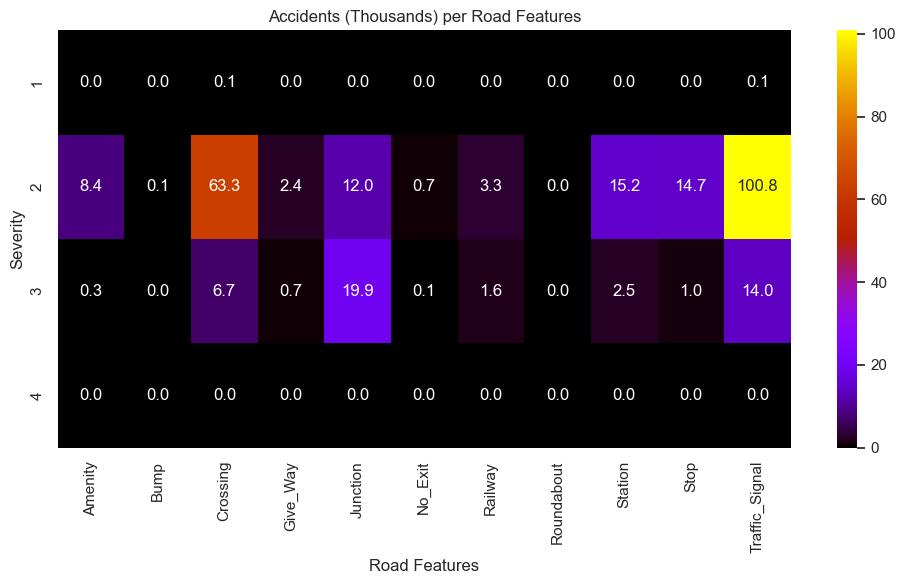

In [23]:
# Create a new dataset with boolean columns and severity
bool_severity_dataset = accidents[['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                              'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Signal']].copy()

# Calculate the number of accidents for each combination of severity and boolean columns
accidents_by_bool_severity = bool_severity_dataset.groupby(['Severity']).sum()

# Create a heatmap to visualize the relationship between accident severity and boolean columns
plt.figure(figsize=(10, 6))
sns.heatmap(data=accidents_by_bool_severity/1000, cmap='gnuplot', annot=True, fmt='.1f')
plt.title('Accidents (Thousands) per Road Features')
plt.xlabel('Road Features')
plt.ylabel('Severity')
plt.tight_layout()

plt.show()

From the correlation chart we can see that:

* Junctions, crossings and traffic signals tend to have most car accidents;
* Junctions and traffic signals tend to have the most severe accidents;
* Roundabouts and Turning Loops have the least accidents;

## Folium Map Visualization

* I should note that this heatmap is not scaled to account for traffic levels in these areas, which means it does not show the rate of accidents relative to traffic, but simply the absolute number of accidents.
* Also worth noting that the data is limited to a few states, as seen in the map below.

In [24]:
#*import folium
#from folium.plugins import HeatMap

# Create a folium map centered at a specific location
#m = folium.Map(location=[accident_coords['Start_Lat'].mean(), accident_coords['Start_Lng'].mean()], zoom_start=4.4)

# Convert your data to a list of coordinates
#data = accident_coords[['Start_Lat', 'Start_Lng']].values.tolist()

# Create a HeatMap layer and add it to the folium map
#HeatMap(data).add_to(m)

# Display the folium map


# 4. Feature Extraction & Engineering:

Next, we will be looking at the data to find hidden insights. Here is a brief overview of our manipulations and why they matter:

* Time Insights:
We're tapping into accident timestamps to unveil time-related patterns. Extracting hour, day of the week, month, and time of year helps us spot trends linked to different times—like peak traffic hours or seasonal variations.

* Duration Breakdown:
Calculating accident duration and converting it to minutes helps us understand how long incidents impact roads. Valuable for assessing severity and response times.

* Smart Categories:
We're sorting various factors into categories, from weather conditions to city names. This categorization streamlines data for our models, ensuring they grasp the context and make smarter predictions.

* Trimming the Unnecessary:
We're dropping columns that won't aid our model's mission. Farewell, redundant or overly specific data—your space is better used elsewhere.

These transformations transform raw data into powerful insights. We're preparing our dataset for best performance by giving better context and trends.

In [25]:
# Extract time-related features
accidents['Hour_of_Day'] = accidents['Start_Time'].dt.hour
accidents['Day_of_Week'] = accidents['Start_Time'].dt.dayofweek
accidents['Month'] = accidents['Start_Time'].dt.month
accidents['Time_of_Year'] = accidents['Start_Time'].dt.quarter
accidents['Duration'] = accidents['End_Time'] - accidents['Start_Time']
accidents['Duration_in_minutes'] = accidents['Duration'].dt.total_seconds() / 60

# Create Categories
categories = ['Weather_Condition',  
              'State', 
              'Month', 
              'Time_of_Year', 
              'Day_of_Week',
              'City']

accidents[categories] = accidents[categories].astype('category')

# Drop columns that won't be used in the model
accidents.drop(columns=['End_Time', 'Duration', 'Street', 'Source'], inplace=True)

In [26]:
# Drop the original timestamp column if needed
accidents = accidents.drop('Start_Time', axis=1)

# 5. Preprocessing & Predictive Modeling:

## Preprocessing

During the preprocessing phase, we need to impute missing values in numeric features using the mean of each respective column, ensuring that the subsequent analysis remained uninfluenced by incomplete records. For categorical attributes we can use an 'unknown' category to handle absent data.

We can also standardize & scale numerical features, aiding in the optimization of modeling performance. Categorical variables should be encoded using a one-hot encoding technique, enabling the incorporation of non-ordinal information into the analysis.

The resulting cleaned and transformed dataset can then be used for our model. 

## Predictive Modeling

Having meticulously prepared our dataset, we proceeded to construct a predictive model using the XGBoost algorithm. XGBoost is known for its efficiency and accuracy, enabling us to unravel the intricate relationships between the myriad of features and the target variable—accident severity.

We partitioned the preprocessed dataset into distinct training and testing sets to ensure the model's ability to generalize. Since we have a multi-class classification task, we need to set the model's objective to 'multi:softmax,' accommodating the grading of severity levels spanning 1 to 4.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier

accidents['Severity'] = accidents['Severity'] -1

accidents[['Traffic_Signal']] = accidents[['Traffic_Signal']].astype('int')

# Separate the target variable from the features
y = accidents.pop('Severity')
X = accidents.copy()

# Split the data into train and test sets for both X and y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Columns to include in the pipeline
numeric_cols = ['Distance(mi)', 'Temperature(F)', 'Visibility(mi)','Wind_Speed(mph)', 
                'Precipitation(in)', 'Hour_of_Day', 'Duration_in_minutes',
                'Traffic_Signal']

categorical_cols = categories

# Step 2: Preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 3: Fit the model
xgb_model = XGBClassifier(objective='multi:softmax', 
                          num_class=4, 
                          random_state=42,
                          tree_method='gpu_hist'  # Enable GPU acceleration
                         )

# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Step 5: Make predictions
predictions = pipeline.predict(X_val)


KeyError: 'Severity'

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Evaluate pipeline using cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} +/- {scores.std():.4f}")

# Fit the pipeline on the full training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
predictions = pipeline.predict(X_val)


c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autos

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:50:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:50:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:50:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:50:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:50:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:50:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:50:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:50:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:50:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:50:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device



In [ ]:
column = ['Give_Way','No_Exit','Railway','Amenity','Bump','Crossing','Junction', 'Humidity(%)', 'Roundabout', 'Station', 'Stop']

X_train = X_train.drop(column, axis=1)

In [ ]:
X_train

,Distance(mi),City,State,Country,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,year,Hour_of_Day,Day_of_Week,Month,Time_of_Year,Duration_in_minutes
269056,0.01,Houston,TX,US,60.1,10.0,10.4,NaN,Overcast,1,2017,10,0,1,1,29.800000
499174,0.00,Fort Lauderdale,FL,US,91.0,10.0,11.5,NaN,Scattered Clouds,0,2017,17,3,7,3,29.200000
85143,0.01,Los Angeles,CA,US,79.0,10.0,3.5,NaN,Clear,0,2016,10,2,10,4,34.333333
260335,0.00,York,PA,US,75.9,10.0,4.6,NaN,Clear,0,2016,8,2,7,3,30.000000
338124,0.01,Sacramento,CA,US,44.1,10.0,6.9,NaN,Clear,0,2017,21,4,2,1,29.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.00,Royersford,PA,US,82.9,10.0,5.8,NaN,Clear,1,2016,9,4,7,3,45.000000
365838,0.01,Hazelwood,MO,US,61.0,10.0,15.0,NaN,Scattered Clouds,0,2017,11,2,3,1,29.166667
131932,0.00,Miami,FL,US,73.0,10.0,3.5,NaN,Clear,1,2016,6,4,9,3,44.433333
146867,0.00,Greenwood,SC,US,52.0,10.0,3.5,NaN,Overcast,0,2016,13,2,12,4,29.766667


In [ ]:
column = ['Give_Way','No_Exit','Railway','Amenity','Bump','Crossing','Junction', 'Humidity(%)','Roundabout', 'Station', 'Stop']

X_val = X_val.drop(column, axis=1)

In [ ]:
X_val

,Distance(mi),City,State,Country,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,year,Hour_of_Day,Day_of_Week,Month,Time_of_Year,Duration_in_minutes
104241,0.01,Moreno Valley,CA,US,63.9,10.0,11.5,NaN,Clear,0,2016,17,0,4,2,60.000000
199676,0.01,Fitchburg,MA,US,19.0,10.0,3.5,NaN,Clear,0,2017,9,1,1,1,29.766667
140199,0.00,Fort Lauderdale,FL,US,91.0,10.0,12.7,NaN,Clear,0,2016,17,4,9,3,60.000000
132814,0.00,Bradenton,FL,US,77.0,1.5,3.5,0.08,Heavy Thunderstorms and Rain,1,2016,18,3,9,3,43.850000
408697,0.01,Hawthorne,CA,US,72.0,10.0,8.1,NaN,Clear,0,2017,12,2,5,2,31.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66361,0.01,Los Angeles,CA,US,68.0,9.0,4.6,NaN,Clear,0,2016,10,6,10,4,44.666667
497228,0.00,Sun Valley,CA,US,79.0,10.0,11.5,NaN,Clear,0,2017,18,2,7,3,44.600000
152728,0.00,Roswell,GA,US,72.5,10.0,2.3,NaN,Mostly Cloudy,1,2016,7,0,9,3,60.000000
50155,0.00,Mira Loma,CA,US,93.9,10.0,16.1,NaN,Clear,0,2016,18,2,7,3,30.000000


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming X_train is your training data
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[['City', 'State', 'Country','Day_of_Week', 'Month' , 'Time_of_Year' ]]) 
X_val_encoded = encoder.fit_transform(X_val[['City', 'State', 'Country','Day_of_Week', 'Month' , 'Time_of_Year']])

## Model Results: Confusion Matrix

Below we'll show a Confusion Matrix detailing how the model performed against the real data. Ideally, we would have a perfect bright diagonal, but as you can see below, the model misclassified many of the accidents as having Severity 2. This is something we can try to improve in the next steps.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_val, predictions, target_names=['1', '2', '3', '4'])
print(class_report)

NameError: name 'predictions' is not defined

NameError: name 'predictions' is not defined

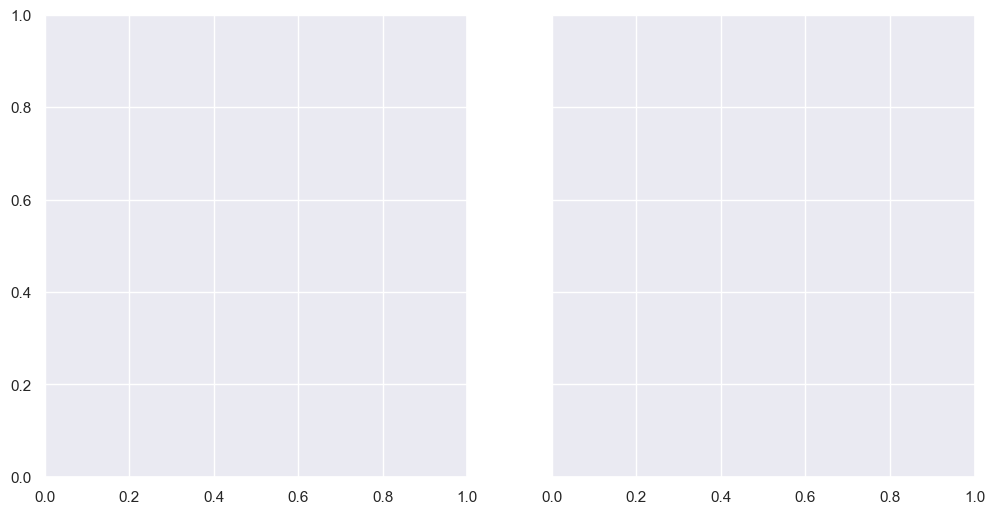

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the predicted distribution
sns.histplot(predictions, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[0], ax=axes[0])
axes[0].set_xlabel('Predicted Severity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Severities')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['1', '2', '3', '4'])

# Plot the actual distribution
sns.histplot(y_val, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[3], ax=axes[1])
axes[1].set_xlabel('Actual Severity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Actual Severities')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(['1', '2', '3', '4'])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = accuracy_score(y_val, predictions)
print("Accuracy:", accuracy)

NameError: name 'predictions' is not defined

# 6. Model Improvement:

For optimization purposes, we will undertake the task of fine-tuning the model's hyperparameters and investigating the potential of L1 and L2 regularization to enhance the accuracy of predictions. Given the substantial size of our dataset, the emphasis for now will be on these optimization steps, while temporarily setting aside the consideration of cross-validation.

In [ ]:
# Set new hyperparameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,  # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metric
    'eta': 0.01,  # Lower learning rate to encourage exploration
    'max_depth': 8,  # Deeper trees for more complex interactions
    'min_child_weight': 2,  # Increase minimum child weight for regularization
    'subsample': 0.7,  # Slightly decrease subsample ratio
    'colsample_bytree': 0.7,  # Slightly decrease column subsample ratio
    'gamma': 0.5,  # Increase minimum loss reduction for partitions
    'reg_alpha': 0.3,  # Regularization for L1
    'reg_lambda': 0.8,  # Keep L2 regularization moderate
    'tree_method': 'gpu_hist'  # Enable GPU acceleration
}

# Create the XGBoost model
new_model = XGBClassifier(**params)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', new_model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
new_predictions = pipeline.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the pipeline
print(classification_report(y_val, new_predictions))

c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Shraiy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBoostError: [12:33:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [12:33:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


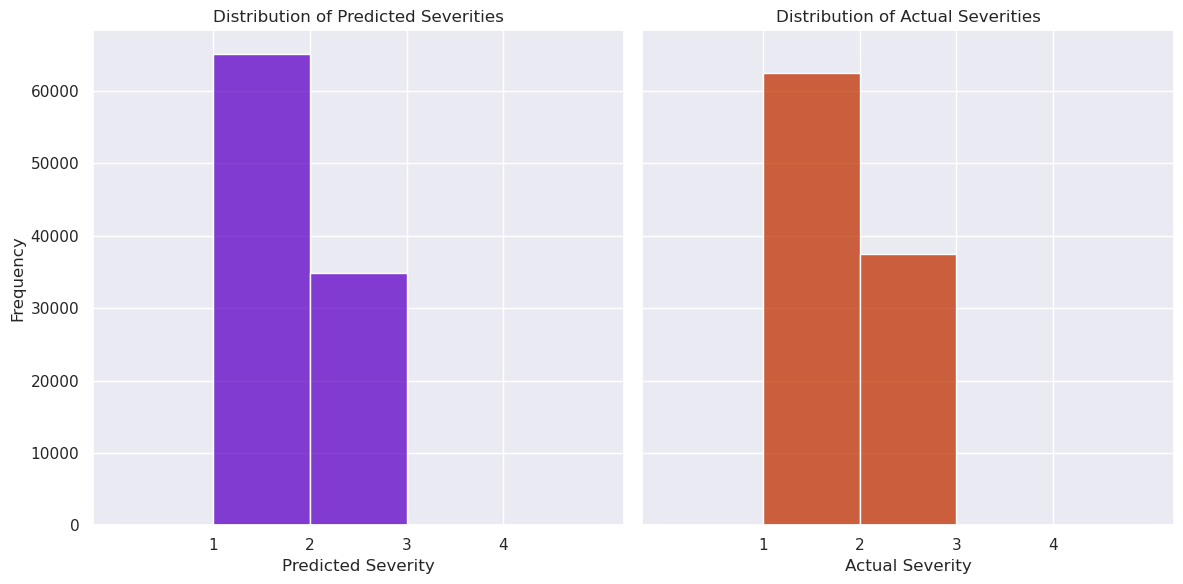

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the predicted distribution
sns.histplot(new_predictions, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[0], ax=axes[0])
axes[0].set_xlabel('Predicted Severity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Severities')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['1', '2', '3', '4'])

# Plot the actual distribution
sns.histplot(y_val, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[3], ax=axes[1])
axes[1].set_xlabel('Actual Severity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Actual Severities')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(['1', '2', '3', '4'])

plt.tight_layout()
plt.show()

In [ ]:
accuracy = accuracy_score(y_val, new_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.81505


# 8. Performance Evaluation:

Upon comparing the performances of both models, it appears that there is limited room for significant enhancement in the model's efficiency at this juncture. It's plausible that further iterations may benefit from additional feature engineering or refined fine-tuning to yield more substantial improvements. However, for the current iteration, these efforts conclude our optimization endeavors.

As we conclude this notebook, we'll delve into the extraction of feature importances, shedding light on the factors that wielded significant influence over the algorithm's predictive outcomes. It's important to highlight that the weight of feature importances doesn't necessarily correlate with a higher severity rating; rather, these attributes proved to be more informative, aiding the algorithm in deciphering the intricacies of accident severity determination.

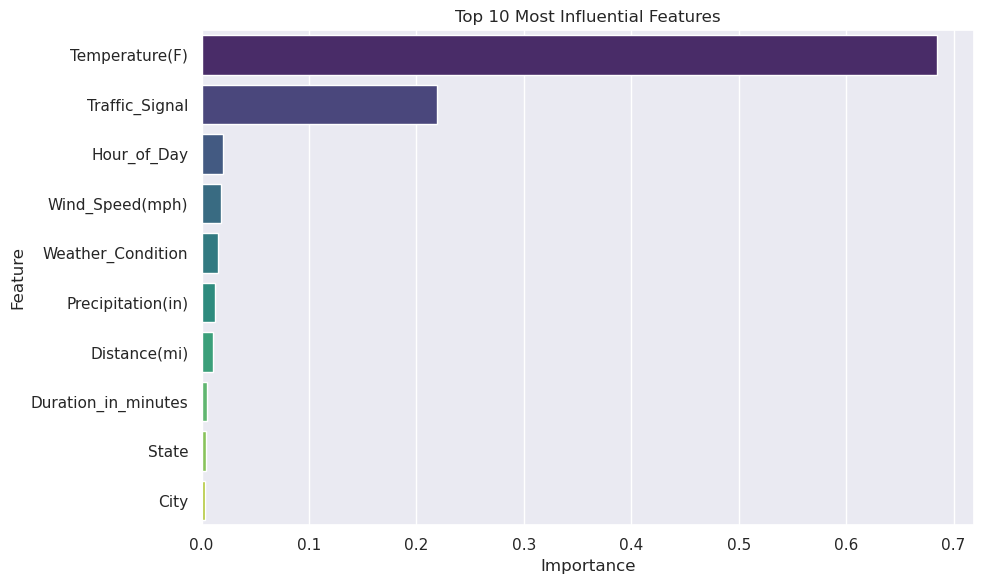

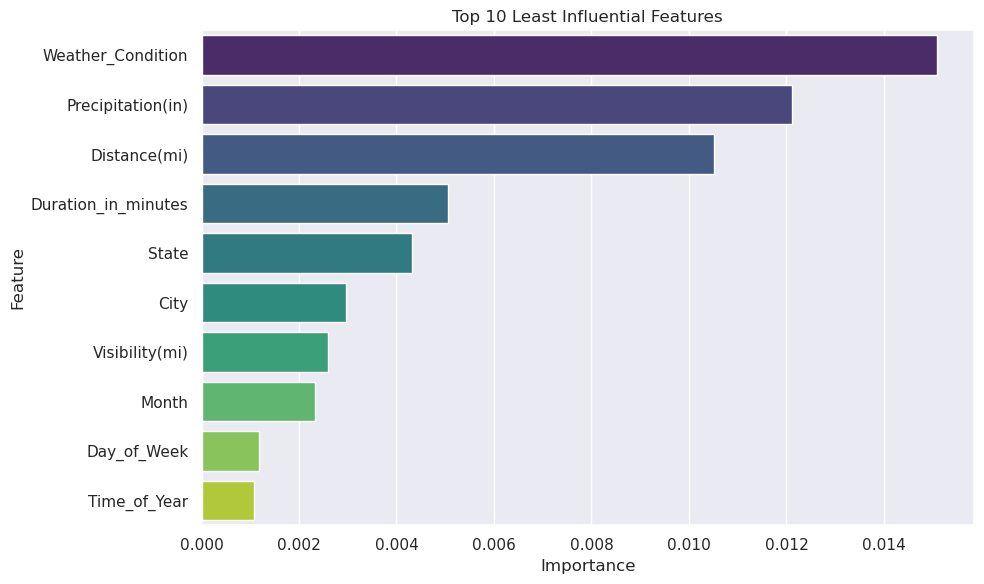

In [ ]:
# Get feature importances from the XGBoost model inside the pipeline
feature_importances = pipeline.named_steps['model'].feature_importances_

# Get the column names from the preprocessor
categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out()

all_feature_names = np.concatenate([categories, numeric_cols])

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Generate elegant Seaborn bar charts for most and least influential features
plt.figure(figsize=(10, 6))

# Most influential features
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Least influential features
sns.barplot(data=importance_df.tail(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Least Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()